*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Transformers BERT モデル (PyTorch) による日本語文章のテキスト分類

## ライブラリのインポート

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import scrapbook as sb
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# # path の追加
# sys.path.append('../..')

from utils_nlp.common.timer import Timer
from utils_nlp.common.pytorch_utils import dataloader_from_dataset
from utils_nlp.dataset.multinli import load_pandas_df
from utils_nlp.models.transformers.sequence_classification import (
    Processor, SequenceClassifier)

from azureml.core import Workspace, Datastore, Dataset

# 表示する列データの幅を変更
pd.set_option("display.max_colwidth", 1000)

In [2]:
# 念のため Transformer Version 確認
import transformers
transformers.__version__

'2.6.0'

## 事前準備
本ノートブックでは日本語対応BERTモデルのファインチューニングと評価を行います。

ここでは、[Hugging Face's PyTorch implementation](https://github.com/huggingface/transformers) をラップした [sequence classifier](../../utils_nlp/models/transformers/sequence_classification.py)を利用します。本コードでは、**bert-base-japanase-whole-word-masking** という学習済みモデルを利用します。 

In [4]:
# パラメータ
DATA_FOLDER = TemporaryDirectory().name
CACHE_DIR = TemporaryDirectory().name
NUM_EPOCHS = 1
BATCH_SIZE = 16
NUM_GPUS = 2
MAX_LEN = 100
TRAIN_DATA_FRACTION =1 #サンプリングする場合は割合(<1)を指定
TEST_DATA_FRACTION =1 #サンプリングする場合は割合(<1)を指定
TRAIN_SIZE = 0.75
LABEL_COL = "label" # ラベルを含む列名
TEXT_COL = "text" # テキストを含む列名
MODEL_NAMES = ["bert-base-japanese-whole-word-masking"] #利用するモデル

## データセットの読み込み
[Livedoor ニュースコーパス](https://www.rondhuit.com/download/ldcc-20140209.tar.gz)をダウンロードして利用します。
<!-- データのダウンロードと加工手順は [bert-japanese](https://github.com/yoheikikuta/bert-japanese/) を参考にしています。 -->

In [5]:
# data_dir = "data/"
# if not os.path.exists(data_dir):
#     os.mkdir(data_dir)

In [ ]:
# import tarfile

# with tarfile.open('ldcc-20140209.tar.gz', 'r:gz') as tar:
#     tar.extractall(path='livedoor')
#     tar.close()

In [ ]:
# from azureml.core.authentication import InteractiveLoginAuthentication
# interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")
# ws = Workspace.from_config(auth=interactive_auth)
# print(ws)

In [6]:
ws = Workspace.from_config()

In [ ]:
# from urllib.request import urlretrieve
# import tarfile

# text_url = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
# file_path = "./data/ldcc-20140209.tar.gz"
# urlretrieve(text_url, file_path)

# mode = "r:gz"
# tar = tarfile.open(file_path, mode) 
# tar.extractall("./data/livedoor") 
# tar.close()

In [ ]:
#df = pd.read_csv('livedoor-corpus-full.tsv', delimiter='\t')

In [8]:
dataset = Dataset.get_by_name(ws, name='livedoor-tabular')
df = dataset.to_pandas_dataframe()

/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/azureml/dataprep/api/dataflow.py:620: UserWarning: Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install azureml-dataprep[pandas].
  warnings.warn('Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. '


欠損値を除外します

In [9]:
df = df[pd.isna(df["text"])==False]

In [10]:
# 列名一覧
df.columns

Index(['text', 'label'], dtype='object')

In [11]:
df.head()

,text,label
0,友人代表のスピーチ、独女はどうこなしている？もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？ さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」さてそんなとき、独女はどう対応したらいいか？最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳）「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」サプライズスピーチのメリットとしては、準備していない状態なので、フランクな本音をしゃべってもらえるという楽しさがあるようだ。しかしそれも上手に対応できる人ならいいが、苦手な人の場合だと「フランク」ではなく「しどろもどろ」になる危険性大。ちなみにプロの司会者の場合、本当のサプライズではなく式の最中に「のちほどサプライズスピーチとしてご指名させてい...,dokujo-tsushin
1,ネットで断ち切れない元カレとの縁携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書かれた相手の連絡先を涙ながらに消す。そうすれば、いつしか縁は切れていったものである。しかし現在は、携帯電話がありメールがあり、インターネットを開けば、ブログで相手の晩飯までわかってしまう赤裸々なご時世。切っても切れない元カレとの縁に独女たちは何を思うのであろうか？「5年前に別れた彼からメールが届いてビックリしました」とは尚美さん（36歳）「彼の浮気が原因で別れたのですが、現在は独り身らしいことが書いてありました。ただ、私には婚約間近の恋人がいるのでスルー。もし自分に相手がいなかったら、復活愛はあったかも。出会いの機会が少ない独女にとって、いい時代と言えるのでは？」彼と交際していた当時、尚美さんは実家に住んでいた。もしもメールも携帯電話もない時代だったら、恐らく彼からの連絡はあり得なかっただろう。一方、美加子さん（38歳）は「一般電話だけの時代のほうが、縁を切りにくかったですよ」という。「今はメモリ頼りになっている分、電話番号やメールアドレスを消去してしまえばそれまでってところがありますからね。ずるずる引きずろうと思えば引きずれるし、切ろうと思えば切れる。ひと昔前は彼の電話番号を暗記していたものです。受話器を上げたり戻したり……気持ちを断つのが難しかったなぁ」知恵さん（34歳）も同意見だ。「情報は自分が情報網を使えば入ってくるが 自分次第でシャットアウトできるもの。だけど私は、“別れた彼と絶縁すべき”とは思っていません。心が癒されるまでの期間は連絡を断ちきり、それ以降はメールを送るなどして、友達関係に戻ることが多いですね」オール・オア・ナッシングだった以前に比べ、今は縁を切る、友人に戻る、メル友関係を続けるなど、別れた後の関係性を選択できるようになった。未練が残っているうちは辛いが、ツールを上手く使えばメリットを得られることもあるだろう。ただし、落とし穴もある。最後に、律子さん（35歳）のトホホな話を紹介。「10年前につきあっていた元彼とは、節目節目にメールをしています。“マイミク”で日記にコメントを書き込んだりもするし、年賀状もやりとりする仲。元彼はすでに結婚して子どもが二人いるんですね。最近はすっかり中年太りしてきてマイホームパパって感...,dokujo-tsushin
2,相次ぐ芸能人の“すっぴん”披露 その時、独女の心境は？「男性はやっぱり、女性の“すっぴん”が大好きなんですかね」と不満そうに話すのは、出版関係で働く香さん（仮名／31歳）。というのも、最近ブログにすっぴん写真を掲載する芸能人が多く、それがニュースになり話題になることがあるからだ。今年に入ってから、“すっぴん”をブログで披露した芸能人は、小倉優子、安倍なつみ、モーニング娘。の田中れいな、優木まおみ、仲里依紗など、年齢も活躍しているジャンルも様々。私生活をリアルタイムに発信できるブログだからこそ、皆それぞれにリラックスした表情で自分のすっぴんを公開している。ファンにとっては、好きな芸能人の素顔が垣間見れる嬉しいサービスなのだろう。では、なぜ芸能人のすっぴん顔披露に、彼女は疑問を抱いたのだろうか。「私のひがみだと言う事は重々承知なんですけど、“随分自分に自信があるんだな”って、素直にその美しさを認める事が出来なくて…」と話す香さん。「コメントに“すっぴんでもかわいい！”とか、“メイクしなくても全然OK！”とか賞賛ばかりが並ぶのを見越して、すっぴん写真を公開してるんだなって思うと何か複雑ですね」と付け加えた。本来ファンサービスである為のすっぴん披露を、「話題を呼ぶ為や、コメントで褒められたいから」行っているのでは？ と、独女はつい“ナナメ”に見てしまう様だ。また、メーカーで営業をしている裕美さん（仮名／32歳）は「男性の“すっぴん幻想”には参りますね。そりゃ素顔がキレイならば私だってすっぴんで出社しますよ。でも、毎日少しでもキレイになりたいと一生懸命メイクしている努力も認めて欲しいな」と独女なりの乙女心を明かしてくれた。「10代や20代前半の若い女の子がすっぴんを載せているのは、“ああ、やっぱり可愛いな”と心から思えるんですけど、私と同年代の人が披露していると自分のすっぴんと比べてゲンナリします」と、美しい芸能人すっぴんを見た後に独女達は人知れず傷ついているのである。さて、芸能人のすっぴん披露、実際に男性の評判はどうなのだろうか。アパレル企業に勤める雄介さん（仮名／34歳）は「個人的に女性のメイクした顔に魅力を感じないから、すっぴんを見るとすごく可愛いと思う」と賛成派。一方、IT企業で働く徹さん（仮名／28歳）は「人によるけど、何でわざわざブログに載せるんだろうとは...,dokujo-tsushin
3,ムダな抵抗！？ 加齢の現実ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「そげる→たわむ→外に流れる」という。バストの変化はすでに20代から始まり、20代にして「たわむ」になっている人もいる。そして、元に戻った人は一人もいない。さらに、体の各部位の20代〜50代までの変化をみると、ウエストとお腹の変化が最も大きく、お腹はバストと同じ大きさになっている。これは、４月に開催されたワコール人間科学研究所の記者発表「からだのエイジング（加齢による体型変化）について一定の法則を発見」での内容の一部。延べ4万人分の経年変化の数値を集計・分析したデータとともに、写真や映像で説明させるので説得力は抜群だ。現実を直視させられた後に、体型変化の少ない人達の身体的特徴や日常の行動・意識を紹介。その主な内容は、日頃から体を動かし、姿勢をチェック、下着は必ず試着してフィット感を確かめるというもの。そして、パネルディスカッションでは、歩幅の広い歩き方を１年間続ける実験に参加した人が、背筋が伸び、脂肪が落ちたという結果などが紹介されていた。興味は尽きず、知人たちに内容を伝えるとさまざまな意見や経験が聞けた。「ずっと計測されているから、体型変化の少ない人はスポーツをしてたのでは？」という疑問もあったが、この回答は、「運動を一生懸命しているというより日常生活を気をつけている印象が強い。そして、ダイエットはあまりしたことがない」とのこと。「叔母もそんなことを言っていた」と言うのはＹ子。60歳代の叔母さんが友人たちと温泉旅行に行ったとき、「バストの変化が少ないとほめられた」と喜んでいたので、バストのケア方法を尋ねたそうだ。「叔母はブラジャーを常に着用し、購入時は必ず計測して試着している。一方、友人達は『苦しい』からと家ではブラジャーをしないこともあるらしい」。それを聞いて以来、Ｙ子は下着を買うときには試着はもちろん、計ってもらうようにしている。「私も歩いてやせた」と話すのは、腰痛に悩まされていたＫ子。医師に筋力の低下を指摘されて、駅までの自転車を止めて、片道30分の道のりを毎日往復歩くことに。筋力をつけるために始めたことで体全体が引き締まり、結果として減量に

本データセットでは9種類のラベルに分類されます。それぞれのデータ数を確認します。

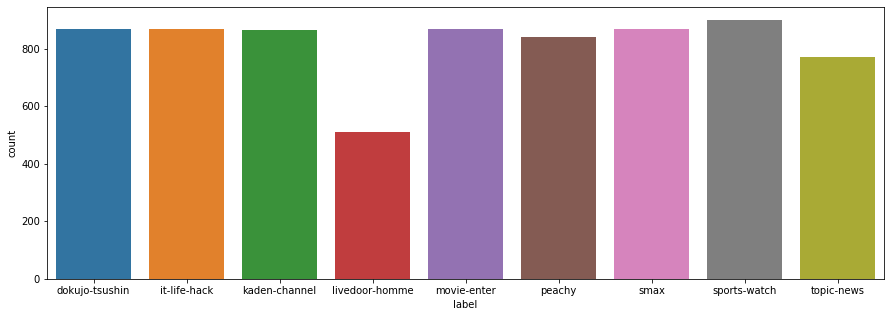

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
sns.countplot(df[LABEL_COL])

データを学習用、テスト用に分割します。またラベル名をエンコーディングしてBERTで扱えるようにします。

In [13]:
# データ分割
df_train, df_test = train_test_split(df, train_size = TRAIN_SIZE, random_state=0)

/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# # 必要であればサンプリング
# df_train = df_train.sample(frac=TRAIN_DATA_FRACTION).reset_index(drop=True)
# df_test = df_test.sample(frac=TEST_DATA_FRACTION).reset_index(drop=True)

In [15]:
# ラベルのエンコーディング
label_encoder = LabelEncoder()
df_train[LABEL_COL] = label_encoder.fit_transform(df_train[LABEL_COL])
df_test[LABEL_COL] = label_encoder.transform(df_test[LABEL_COL])

num_labels = len(np.unique(df_train[LABEL_COL]))

/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 9
Number of training examples: 5525
Number of testing examples: 1842


## 学習済みモデルの選択

[Hugging Face](https://github.com/huggingface/transformers) には学習済みモデルが公開されており簡単に利用することができます。テキスト分類で利用できるモデル一覧を出力します。

In [17]:
pd.DataFrame({"モデル名": SequenceClassifier.list_supported_models()})

,モデル名
0,bert-base-uncased
1,bert-large-uncased
2,bert-base-cased
3,bert-large-cased
4,bert-base-multilingual-uncased
5,bert-base-multilingual-cased
6,bert-base-chinese
7,bert-base-german-cased
8,bert-large-uncased-whole-word-masking
9,bert-large-cased-whole-word-masking


## ファインチューニング

本コードで実装されているラッパーを利用することで簡単にファインチューニングが実行できます。

In [18]:
# 利用するモデル名
print(MODEL_NAMES)

['bert-base-japanese-whole-word-masking']


データ前処理、ファインチューニング、テストデータの予測、評価をステップを実施していきます。

In [19]:
results = {}

model_name = MODEL_NAMES[0]

# 前処理
processor = Processor(
    model_name=model_name,
    to_lower=model_name.endswith("uncased"),
    cache_dir=CACHE_DIR,
)

In [20]:
train_dataset = processor.dataset_from_dataframe(
    df_train, TEXT_COL, LABEL_COL, max_len=MAX_LEN
)
train_dataloader = dataloader_from_dataset(
    train_dataset, batch_size=BATCH_SIZE, num_gpus=NUM_GPUS, shuffle=True
)
test_dataset = processor.dataset_from_dataframe(
    df_test, TEXT_COL, LABEL_COL, max_len=MAX_LEN
)
test_dataloader = dataloader_from_dataset(
    test_dataset, batch_size=BATCH_SIZE, num_gpus=NUM_GPUS, shuffle=False
)

In [21]:
# ファインチューニング
classifier = SequenceClassifier(
    model_name=model_name, num_labels=num_labels, cache_dir=CACHE_DIR
)

In [22]:
with Timer() as t:
    classifier.fit(
        train_dataloader, num_epochs=NUM_EPOCHS, num_gpus=NUM_GPUS, verbose=False,
    )
train_time = t.interval / 3600

In [23]:
# テストデータの予測
preds = classifier.predict(test_dataloader, num_gpus=NUM_GPUS, verbose=False)

# 評価
accuracy = accuracy_score(df_test[LABEL_COL], preds)
class_report = classification_report(
    df_test[LABEL_COL], preds, target_names=label_encoder.classes_, output_dict=True
)

# 結果の保存
results[model_name] = {
    "accuracy": accuracy,
    "f1-score": class_report["macro avg"]["f1-score"],
    "time(hrs)": train_time,
}

In [24]:
df_test[LABEL_COL] = label_encoder.inverse_transform(df_test[LABEL_COL])
df_test["pred"] = label_encoder.inverse_transform(preds)

/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/nlp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
df_test.head(1)

,text,label,pred
3162,インタビュ—：ティム・ディケイ（ピーター・バーク役）——犯罪ドラマが色々ある中で、この『ホワイト・カラー』はとりわけ人気を集めていますが、その人気の秘密はどこにあると思いますか？ティム・ディケイ：犯罪ドラマというのは普通、主人公達が家に帰るところまで見せないで、犯罪そのものについての物語だと思うんだ。でも、僕らの番組は、それよりもむしろ人間関係について描いたものである、ということが大きな違いだと思うんだよね。だから何が盗まれたとか取られたみたいなことはあまりに重要ではない。視聴者にとって大事なのは、ピーター（・バーク）とニール（・キャフリー）の人間関係であり、ふたりがどのようにして悪者を見付けていくのかという部分なんだ。それに僕自身、俳優としても、犯罪について描くよりも、人間関係について扱うほうが、ずっと面白いからね。——ピーターとニールの相性がすごく良いと思うのですが、話し合いなどをしてこの作品に取り組んだのですか？父親と息子であったり、兄弟的であったり、すごく家族的なところがあるので、良いと思うのですが。ティム・ディケイ：うん、確かにそうだね。だけど、ふたりで改めて話し合ったことはないんだ。まず、彼が先に役に決まっていたんだけど、プロデューサーが僕らの相性を見るために、僕は彼と脚本の読み合わせをしたんだよね。それで読み合わせを始めたその瞬間に、僕らはお互いふたりの関係性が特別なものだというのが分かったんだ。即座にね。それで番組を撮り続けていく過程で、その時々の物語に応じて、ふたりの関係性について話すことはあったけど、全体的な関係性について話し合ったりしたことはないんだ。なぜなら始まった瞬間から、ティム（・ディケイ）とマット（・ボマー）がお互いを好きだということはすぐに分かったし、それにピーターとニールもお互いが好きなんだ。ふたりは、もしかしたら信頼し合ってはいないかもしれない。それでも、お互いが好きであることは確かなんだ。だからこの番組にとっては、ふたりがその根底において、お互い愛があり、大事に思っているということを描き続けることが非常に重要だと思うんだよね。例えば、銃弾がニールに飛んできたら、絶対にピーターは飛び込んでニールを守ろうとすると思うんだ。そして、ニールもピーターのために同じことをすると思うよ。——あなたの演じているピーターというキャラクター...,movie-enter,movie-enter


## 評価

精度、F1-スコア、学習時間を確認します。

In [26]:
df_results = pd.DataFrame(results)
df_results

,bert-base-japanese-whole-word-masking
accuracy,0.916938
f1-score,0.912887
time(hrs),0.019315


In [27]:
# for testing
sb.glue("accuracy", df_results.iloc[0, :].mean())
sb.glue("f1", df_results.iloc[1, :].mean())